# Some Fun with Stock Prices
Here is a little fun with stock prices: trying to find a model to predict stock prices.
Notice that every model so far failed in the long run.
<b>This is not financial advice</b> - it really is used to have some work with LSTMs and feature extraction.
Every model is already failed before even started.

Way more sophisticated and proprietary models are applied in finances.
Most of them fail in the long run as well.
This is not a competing model, but simply a bit of signal processing, and using signals which are extraordinarily hard to predict.

<b>Never use this for financial advice!</b>

This toy example targets to predict market movements over a day.
Firstly, we look into a prediction naively.
After that, we select a couple of alternative stocks in order to boost the predictions.
Then we compare whether we have found a real improvement.

On the theoretical side, this is a typical scenario in time series analysis.
Find correlated data sets, to predict an outcome.
Annectodtally, the authors have visited a conference on pattern recognition in 2012 where a keynote speaker told that this using correlated stocks was really implemented.
The examples given were Coca Cola and Pepsi.
However, LSTMs were not hinted back then.
We are certain that this was implemented in one form or another.

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from math import ceil
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import wilcoxon

# Download latest version
path: str = kagglehub.dataset_download("farukece/semiconductor-stocks-and-the-ai-surge")

file_path: str = os.path.join(path, os.listdir(path)[0])
print(file_path)

2025-09-11 14:45:22.083993: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-11 14:45:22.091664: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-11 14:45:22.379184: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-11 14:45:23.494870: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

/home/dierck/.cache/kagglehub/datasets/farukece/semiconductor-stocks-and-the-ai-surge/versions/1/semi_conductor_se.csv


In [2]:
TRAIN_RATIO: float = 0.7  # how much of the data is for training
VALID_RATIO: float = 0.15  # how much is for validation
SEQUENCE_LENGTH: int = 21  # the last trade days are in all sequences
MIN_SAMPLE_SIZE: int = 1000  # exclude those stocks which have too view samples
CORRELATION_BOOSTERS: int = 2  # how many alternative stocks are taken to try to boost the prediction results
ISOLATED_MODEL_PREFIX: str = "IsolatedTraining"
MULTI_SEQUENCE_PREFIX: str = "MultiSequenceTraining"

In [3]:
data_frame: pd.DataFrame = pd.read_csv(file_path, index_col=0)
data_frame.head(3)

,company_name,stock_name,date,open,high,low,close,volume
0,NVIDIA,NVDA,2012-01-03,0.327805,0.330097,0.321157,0.321845,468044000
1,NVIDIA,NVDA,2012-01-04,0.322074,0.326888,0.319094,0.325513,347372000
2,NVIDIA,NVDA,2012-01-05,0.323908,0.338808,0.322533,0.337204,563548000


In [4]:
# just find the unique stock names, we want to correleate the data later
unique_stock_names: np.array = data_frame["stock_name"].unique()

In [5]:
data_frame["company_name"] = data_frame["company_name"].astype(str)
data_frame["stock_name"] = data_frame["stock_name"].astype(str)
data_frame["date"] = pd.to_datetime(data_frame["date"])

data_frame.head(3)

,company_name,stock_name,date,open,high,low,close,volume
0,NVIDIA,NVDA,2012-01-03,0.327805,0.330097,0.321157,0.321845,468044000
1,NVIDIA,NVDA,2012-01-04,0.322074,0.326888,0.319094,0.325513,347372000
2,NVIDIA,NVDA,2012-01-05,0.323908,0.338808,0.322533,0.337204,563548000


In [6]:
# check boundaries: are there any NaNs?
print(f"Elements NAN: \"OPEN\" {data_frame["open"].isna().sum()}")
print(f"Elements NAN: \"HIGH\" {data_frame["high"].isna().sum()}")
print(f"Elements NAN: \"LOW\" {data_frame["low"].isna().sum()}")

Elements NAN: "OPEN" 0
Elements NAN: "HIGH" 0
Elements NAN: "LOW" 0


No NaNs is good news, we don't need to care about filling out missing values.
Now we add the true measure we want to use: logarithmic ratio between the closing price and the opening price.
This is independent from the individual price, this is simple the measure how much the stock prices have changed.
Negative values mean that the price fell, positive that it increased.
What we want to do is to predict how much this changes per day.

In [7]:
data_frame.loc[:, "ratio"] = np.log(data_frame["close"]) - np.log(data_frame["open"])
data_frame.head(3)

,company_name,stock_name,date,open,high,low,close,volume,ratio
0,NVIDIA,NVDA,2012-01-03,0.327805,0.330097,0.321157,0.321845,468044000,-0.018349
1,NVIDIA,NVDA,2012-01-04,0.322074,0.326888,0.319094,0.325513,347372000,0.010620
2,NVIDIA,NVDA,2012-01-05,0.323908,0.338808,0.322533,0.337204,563548000,0.040227


In [8]:
valid_stocks = []
for stock_id in unique_stock_names:
    d_selected = data_frame[data_frame["stock_name"] == stock_id]
    n_samples = len(d_selected)
    if n_samples < MIN_SAMPLE_SIZE:
        print(f"{stock_id}: {n_samples} entries - dropped")
    else:
        print(f"{stock_id}: {n_samples} entries")
        valid_stocks.append(stock_id)

unique_stock_names = valid_stocks

NVDA: 3415 entries
AVGO: 3415 entries
TSM: 3415 entries
005930.KS: 3338 entries
AMD: 3415 entries
ASML: 3415 entries
TXN: 3415 entries
QCOM: 3415 entries
ARM: 472 entries - dropped
AMAT: 3415 entries
000660.KS: 3338 entries
LRCX: 3415 entries
MU: 3415 entries
KLAC: 3415 entries
SNPS: 3415 entries
ADI: 3415 entries
INTC: 3415 entries
2454.TW: 3314 entries
8035.T: 3346 entries
MRVL: 3415 entries
0981.HK: 3345 entries
NXPI: 3415 entries
IFX.DE: 3448 entries
6857.T: 3346 entries
688256.SS: 1223 entries
MPWR: 3415 entries
MCHP: 3415 entries
002371.SZ: 3296 entries
6146.T: 3346 entries
ASM.AS: 3475 entries
ON: 3415 entries
ASX: 3415 entries
STM: 3415 entries
6723.T: 3346 entries
ALAB: 343 entries - dropped
GFS: 943 entries - dropped
CRDO: 881 entries - dropped
UMC: 3415 entries
688012.SS: 1464 entries
COHR: 3415 entries
ENTG: 3415 entries
BESI.AS: 3475 entries
603986.SS: 2172 entries
3661.TW: 3126 entries
SWKS: 3415 entries
MTSI: 3365 entries
3034.TW: 3314 entries
2379.TW: 3314 entries
2301.

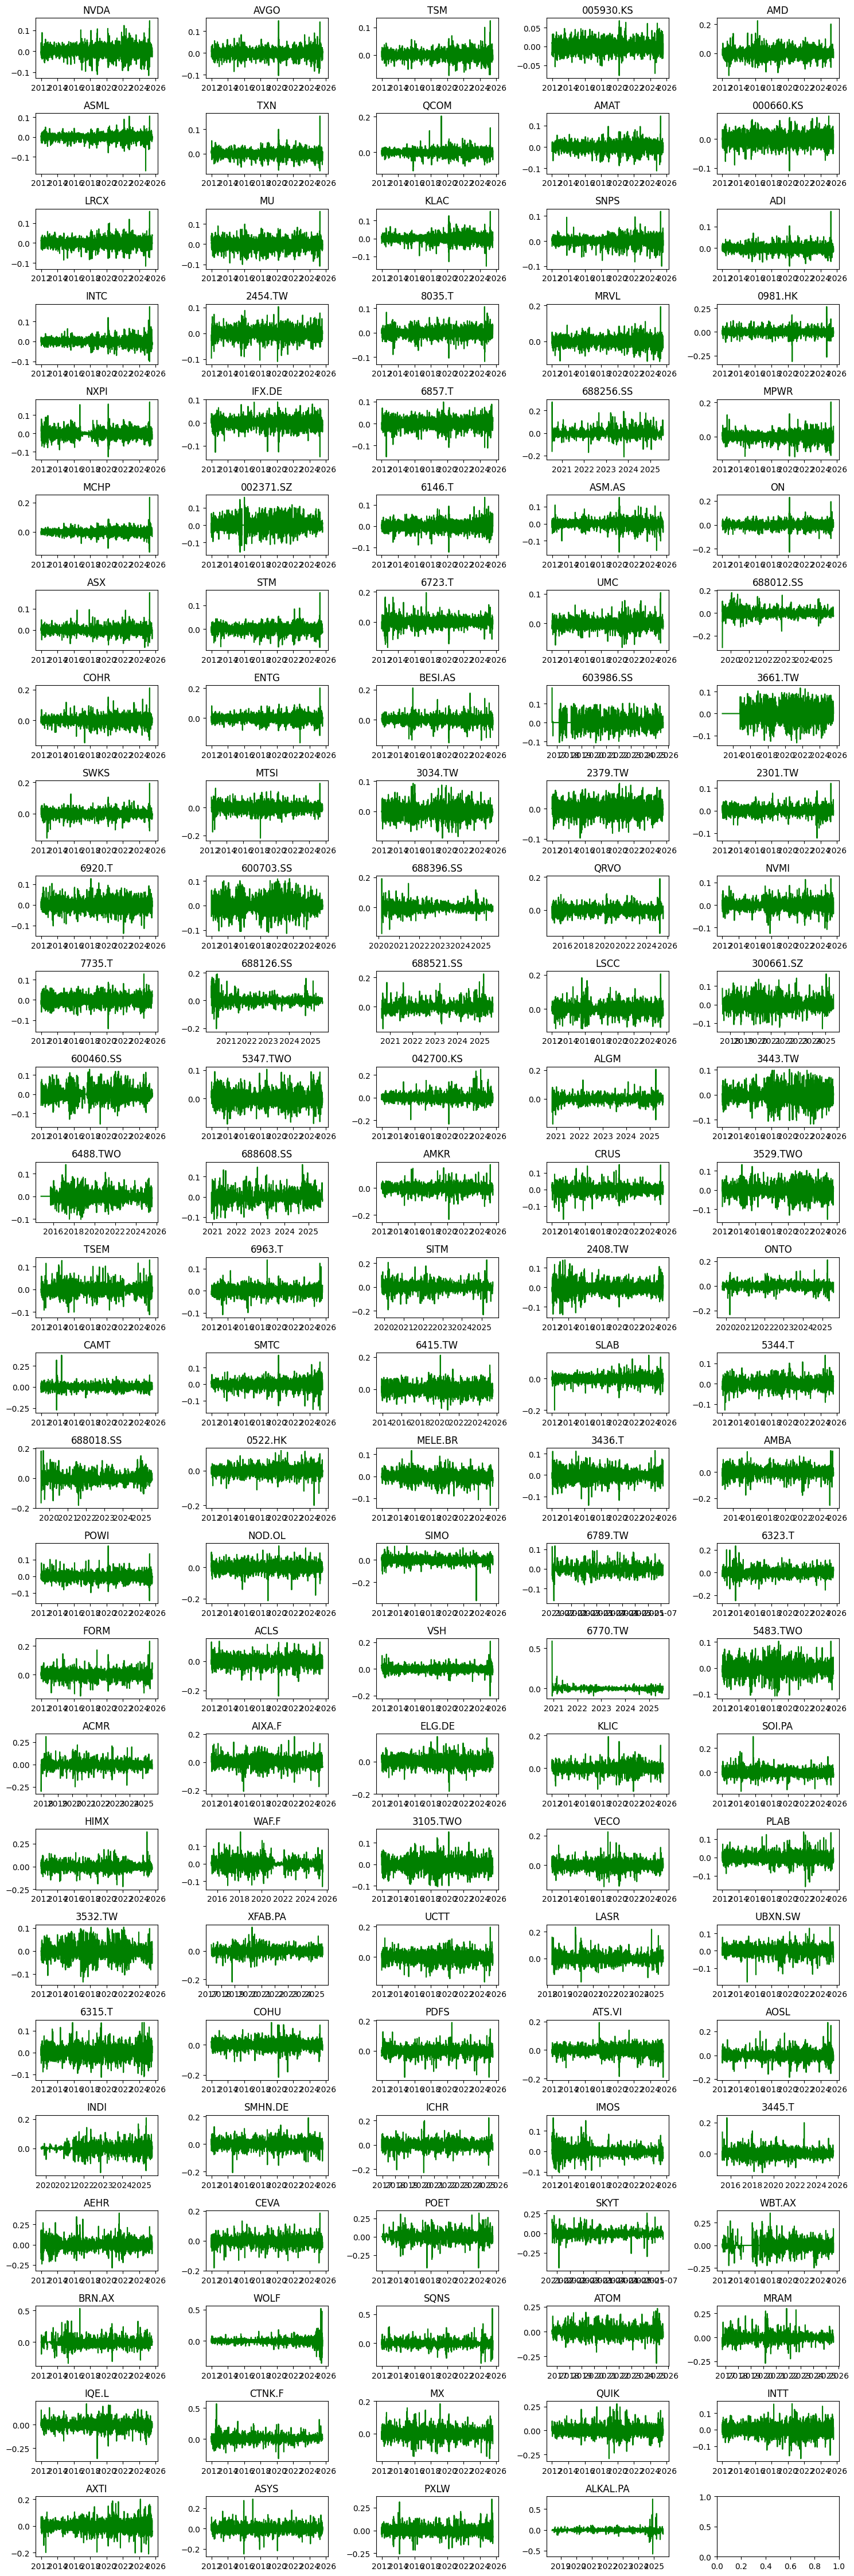

In [9]:
n_stocks: int = len(unique_stock_names)
grid_width = 5
grid_height = ceil(n_stocks / grid_width)

fig, axes = plt.subplots(grid_height, grid_width, figsize=(15,45))
r, c = 0, 0
for i, stock_id in enumerate(unique_stock_names):
    d = data_frame[data_frame["stock_name"] == stock_id]
    d_time = d["date"]
    d_ratio = d["ratio"]
    ax = axes[r, c]
    ax.plot(d_time, d_ratio, "g")
    ax.set_title(stock_id)
    c += 1
    if c == grid_width:
        c = 0
        r += 1

plt.tight_layout()
plt.show()

In [10]:
def sequence_generator(data: np.array, seq_length: int,
                       start_idx: int,
                       end_idx: int,
                       batch_size: int = 32,
                      verbose: bool = False):
    i = start_idx
    if verbose:
        print(f"Init: {start_idx}, end: {end_idx}")
    while i + seq_length < end_idx:
        if verbose:
            print(f"current batch start: {i}")
        X_batch, y_batch = [], []
        for _ in range(batch_size):
            if i + seq_length >= end_idx:
                break
            X_batch.append(data[i:i + seq_length])
            y_batch.append(data[i+seq_length])
            i += 1
        if len(X_batch) == batch_size:
            yield np.array(X_batch), np.array(y_batch)

In [11]:
# data preparation

scalers = {}
train_gens = {}
valid_gens = {}
test_gens = {}
models = {}
test_data_lengths = {}

for stock_id in unique_stock_names:
    n_samples: int = len(data_frame[data_frame["stock_name"] == stock_id])
    n_train = int(TRAIN_RATIO * n_samples)
    n_valid = int(VALID_RATIO * n_samples)
    ratio_data: np.array = data_frame[data_frame["stock_name"] == stock_id]["ratio"].values.reshape(-1, 1)
    scaler: MinMaxScaler = MinMaxScaler()
    scaler.fit(ratio_data[:n_train])
    ratio_data = scaler.transform(ratio_data)
    train_gen = sequence_generator(ratio_data, 
                                   SEQUENCE_LENGTH, 
                                   start_idx=0,
                                   end_idx=n_train)
    valid_gen = sequence_generator(ratio_data,
                                   SEQUENCE_LENGTH,
                                   start_idx=n_train,
                                   end_idx=n_train + n_valid)
    test_gen = sequence_generator(ratio_data, 
                                  SEQUENCE_LENGTH, 
                                  start_idx=n_train + n_valid, 
                                  end_idx = n_samples)

    file_name: str = ISOLATED_MODEL_PREFIX + stock_id + ".keras"
    if os.path.isfile(file_name):
        model = tf.keras.models.load_model(file_name)
    else:
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(SEQUENCE_LENGTH, 1)),
            tf.keras.layers.LSTM(4),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')

    scalers[stock_id] = scaler
    train_gens[stock_id] = train_gen
    valid_gens[stock_id] = valid_gen
    test_gens[stock_id] = test_gen
    models[stock_id] = model
    test_data_lengths[stock_id] = len(ratio_data) - n_train - n_valid

2025-09-11 14:45:35.596791: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
# now to the real fun: Train the models!

baseline_mses = {}

for stock_id in unique_stock_names:
    train_gen = train_gens[stock_id]
    valid_gen = valid_gens[stock_id]
    test_gen = test_gens[stock_id]
    test_data_length = test_data_lengths[stock_id]
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
    model = models[stock_id]
    file_name: str = ISOLATED_MODEL_PREFIX + stock_id + ".keras"
    if not os.path.isfile(file_name):  # only train if not saved
        history = model.fit(train_gen,
                            validation_data=valid_gen,
                            validation_steps=20,
                            epochs=100,
                            callbacks=[early_stop],
                            verbose=0
                            )
        model.save(file_name)
    predictions = []
    true_values = []
    for X_batch, y_batch in test_gen:
        pred = model.predict(X_batch, verbose=0)
        predictions.append(pred)
        true_values.append(y_batch)

    predictions = np.concatenate(predictions, axis=0)
    true_values = np.concatenate(predictions, axis=0)
    mse = ((true_values - predictions)**2).mean()
    baseline_mses[stock_id] = mse

In [13]:
# now we have a baseline, let us find the best correlating data sequences.

boosters = {}

for stock_id in unique_stock_names:
    data_a = data_frame[data_frame['stock_name'] == stock_id][['date', 'ratio']].set_index('date')
    data_a = data_a.resample('1D').mean().interpolate()
    abs_correlations = {}
    for other_id in unique_stock_names:
        if stock_id == other_id:
            continue

        data_b = data_frame[data_frame['stock_name'] == other_id][['date', 'ratio']].set_index('date')
        data_b = data_b.resample('1D').mean().interpolate()
        data_ab = data_a.join(data_b, how='inner', lsuffix='_'+stock_id, rsuffix='_'+other_id)

        pearson_correlation = data_ab['ratio_'+stock_id].corr(data_ab['ratio_'+other_id])
        abs_correlations[other_id] = abs(pearson_correlation)

    current_boosters = [k for k, v in sorted(abs_correlations.items(),
                                             key=lambda item: item[1], reverse=True)[:CORRELATION_BOOSTERS]]
    boosters[stock_id] = current_boosters

In [14]:
def sequence_generator_nd(data: np.array, seq_length: int,
                          start_idx: int,
                          end_idx: int,
                          batch_size: int = 32,
                          verbose: bool = False):
    i = start_idx
    if verbose:
        print(f"Init: {start_idx}, end: {end_idx}")

    while i + seq_length < end_idx:
        if verbose:
            print(f"current batch start: {i}")
        X_batch, y_batch = [], []
        for _ in range(batch_size):
            if i + seq_length >= end_idx:
                break
            X_batch.append(data[i:i + seq_length])
            y_batch.append(data[i+seq_length, 0])
            i += 1
        if len(X_batch) == batch_size:
            yield np.array(X_batch), np.array(y_batch)

In [15]:
matrix_scalers = {}
matrix_models = {}
matrix_mses = {}

for stock_id in unique_stock_names:
    # now we are dealing with several sequences, we have to be more careful with
    # what we select
    data_target = data_frame[data_frame['stock_name'] == stock_id][['date', 'ratio']].set_index('date')
    data_target.resample('1D').mean().interpolate()
    booster_target = boosters[stock_id]
    for booster in booster_target:
        data_temp = data_frame[data_frame['stock_name'] == booster][['date', 'ratio']].set_index('date')
        data_target = data_target.join(data_temp, how='inner', rsuffix='_' + booster)

    n_samples = len(data_target)
    if n_samples < MIN_SAMPLE_SIZE:
        continue

    n_train = int(TRAIN_RATIO * n_samples)
    n_valid = int(VALID_RATIO * n_samples)

    raw_matrix: np.array = data_target[['ratio', *('ratio_' + x for x in booster_target)]].values

    scaler = MinMaxScaler()
    scaler.fit(raw_matrix[:n_train])

    target_scaler = MinMaxScaler()
    # target_scaler.fit(raw_matrix[:n_train, 0])

    normalized_matrix = scaler.transform(raw_matrix)

    matrix_scalers[stock_id] = {'complete': scaler, 'target': target_scaler}
    train_gen = sequence_generator_nd(normalized_matrix, SEQUENCE_LENGTH, 0, n_train)
    valid_gen = sequence_generator_nd(normalized_matrix, SEQUENCE_LENGTH, n_train, n_train + n_valid)
    test_gen = sequence_generator_nd(normalized_matrix, SEQUENCE_LENGTH, n_train + n_valid, len(normalized_matrix))

    file_name: str = MULTI_SEQUENCE_PREFIX + f"_{CORRELATION_BOOSTERS}_" + stock_id + ".keras"
    if not os.path.isfile(file_name):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(SEQUENCE_LENGTH, CORRELATION_BOOSTERS + 1)),
            tf.keras.layers.LSTM(4),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
    
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=3,
            restore_best_weights=True
        )
    
        history = model.fit(train_gen,
                            validation_data=valid_gen,
                            validation_steps=20,
                            epochs=100,
                            callbacks=[early_stop],
                            verbose=0
                            )
        model.save(file_name)
    else:
        model = tf.keras.models.load_model(file_name)

    matrix_models[stock_id] = model  # save it for later - maybe we want to do something with it

    predictions = []
    true_values = []
    for X_batch, y_batch in test_gen:
        pred = model.predict(X_batch, verbose=0)
        predictions.append(pred)
        true_values.append(y_batch)

    predictions = np.concatenate(predictions, axis=0)
    true_values = np.concatenate(predictions, axis=0)
    mse = ((true_values - predictions)**2).mean()
    matrix_mses[stock_id] = mse

In [18]:
valid_ids = []

for stock_id in unique_stock_names:
    if stock_id in baseline_mses or stock_id in matrix_mses:
        valid_ids.append(stock_id)

baseline = [float(v) for k, v in baseline_mses.items() if k in valid_ids]
boosted = [float(v) for k, v in matrix_mses.items() if k in valid_ids]
stats, p = wilcoxon(baseline, boosted)
print("p-value: ", p)
print("Comparisson (boosted - baseline): ", np.mean(boosted) - np.mean(baseline))

p-value:  3.5002447896968267e-15
Comparisson (boosted - baseline):  0.000561066854478627


# Conclusions

In this experiment, using additional information to predict the increase or decrease of the stocks is slightly worse.
Notice that this is not fully comparable, since we used the full data for the baseline training, but had to limit the sequence to the length of all correlated sequences.
This has a major impact on the results, of course.

A fair comparission would use the same sequences for both tests.
Nevertheless, this notebook is just here to demonstrate typical statistical signal processing work.
First, formulate what the data is supposed to be analyzed for;
second, load and transform the data accordingly;
third, apply a baseline model which can create results;
fourth, create alternative models to see what improvements are possible;
fifth, compare the results.